In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip3 install chainercv

In [3]:
%matplotlib inline
USE_GPU = True

In [4]:
# Python Libraries
import random
import math
import numbers
import platform
import copy

# Importing essential libraries for basic image manipulations.
import numpy as np
import PIL
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tqdm import tqdm

# Importing pytorch libraries
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF

import warnings
warnings.filterwarnings("ignore")

from chainercv.evaluations import eval_semantic_segmentation
from chainercv.datasets import VOCSemanticSegmentationDataset

In [5]:
%run -i 'drive/MyDrive/SemanticSegmentation/helper/voc.py'
%run -i 'drive/MyDrive/SemanticSegmentation/helper/utils.py'
%run -i 'drive/MyDrive/SemanticSegmentation/helper/joint_transforms.py'
%run -i 'drive/MyDrive/SemanticSegmentation/models/ResNet18.py'

# 1. Loading Data

In [6]:
DATASET_PATH = 'datasets'  
trainData = VOCSegmentation(DATASET_PATH, image_set='train', download = True)
valData = VOCSegmentation(DATASET_PATH, image_set='val')

Using downloaded and verified file: datasets/VOCtrainval_11-May-2012.tar


# 2. Exploration

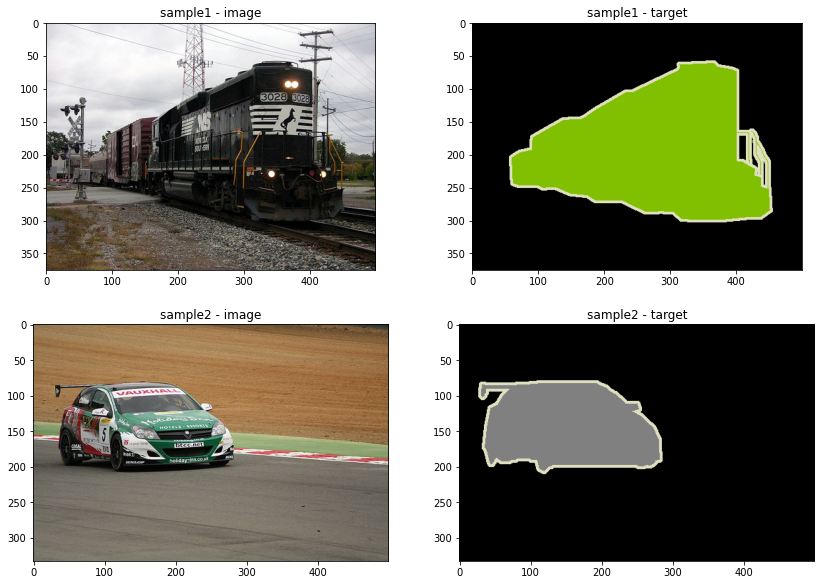

In [7]:
trainIdx = 104
testIdx = 97
sample1 = trainData[trainIdx]
sample2 = valData[testIdx]

# We demonstrate two different (equivalent) ways to access image and target inside the samples.
img1, target1 = sample1
img2 = sample2[0]
target2 = sample2[1]

fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('sample1 - image')
ax1.imshow(img1)
ax2 = fig.add_subplot(2,2,2)
plt.title('sample1 - target')
ax2.imshow(target1)
ax3 = fig.add_subplot(2,2,3)
plt.title('sample2 - image')
ax3.imshow(img2)
ax4 = fig.add_subplot(2,2,4)
plt.title('sample2 - target')
ax4.imshow(target2)

# 3. Transformations

In [8]:
basicTransform = JointCompose(
    [JointToTensor(),
     JointNormalize(*norm)])
trainTransform = JointCompose(
    [JointRandomResizedCrop(0.9,1.4,400),
     JointRandomHorizontalFlip(),
    JointToTensor(),
    JointNormalize(*norm)])
valTransform = JointCompose(
    [JointToTensor(),
     JointNormalize(*norm)])

## 3.1 RandomResized Crop 

Text(0.5, 1.0, 'Transformed Target')

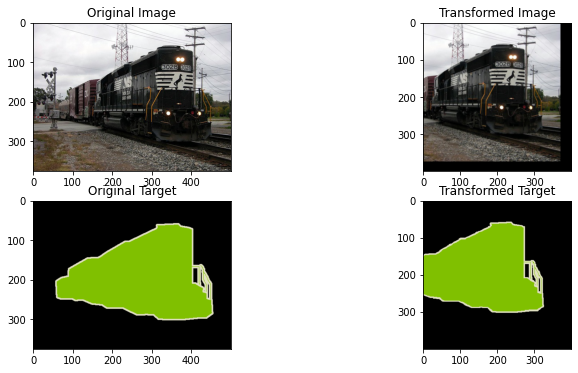

In [9]:
# Student Answer:
tf31 =  JointCompose([JointRandomResizedCrop(0.9,1.4,400)])
ig1, tgt1 = tf31(img1, target1)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(221)
ax1.imshow(img1)
plt.title("Original Image")
ax2 = fig.add_subplot(222)
ax2.imshow(ig1)
plt.title("Transformed Image")
ax3 = fig.add_subplot(223)
ax3.imshow(target1)
plt.title("Original Target")
ax4 = fig.add_subplot(224)
ax4.imshow(tgt1)
plt.title("Transformed Target")

## 3.2 Random Horizontal Flip

Text(0.5, 1.0, 'Transformed Target')

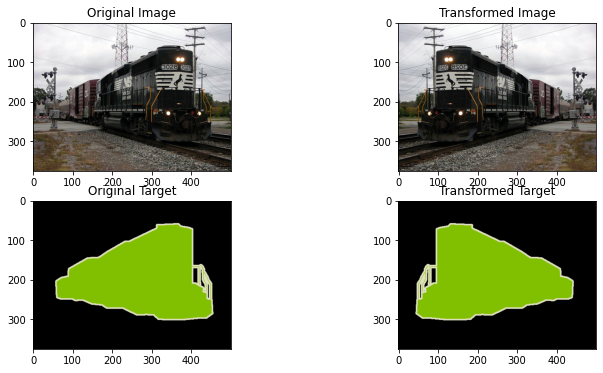

In [10]:
tf32 =  JointCompose([JointRandomHorizontalFlip()])
ig1, tgt1 = tf32(img1, target1)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(221)
ax1.imshow(img1)
plt.title("Original Image")
ax2 = fig.add_subplot(222)
ax2.imshow(ig1)
plt.title("Transformed Image")
ax3 = fig.add_subplot(223)
ax3.imshow(target1)
plt.title("Original Target")
ax4 = fig.add_subplot(224)
ax4.imshow(tgt1)
plt.title("Transformed Target")

# 4. DataLoader Configuration

In [11]:
train_data = VOCSegmentation(
    DATASET_PATH, 
    image_set = 'train', 
    transforms = trainTransform
)

# This is a standard VOC data(sub)set used for validating semantic segmentation networks
val_data = VOCSegmentation(
    DATASET_PATH, 
    image_set='val',
    transforms = valTransform
)

basic_data = VOCSegmentation(
    DATASET_PATH, 
    image_set = 'train',
    transforms = basicTransform,
    sanity_check = trainIdx
)
TRAIN_BATCH_SIZE = 4
NUM_WORKERS = 0

train_loader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1, num_workers=NUM_WORKERS, shuffle=False)
basic_loader = DataLoader(basic_data, batch_size=1, num_workers=NUM_WORKERS, shuffle=False)

# 5. Model Configuration

## 5.1 Initialize Untrained Model

In [12]:
untrained_model = ResNet18(21).eval()

## 5.2 Testing Untrained Model's Performance

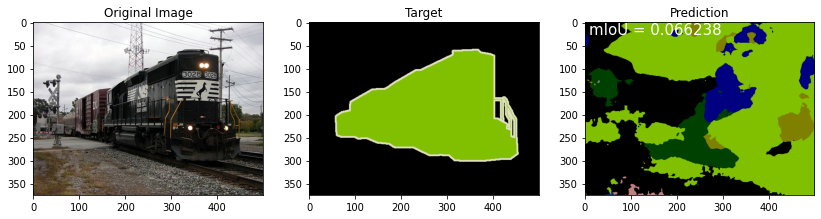

In [13]:
plotPrediction(untrained_model, basicTransform, img1, target1)

# 6. Model Overfitting

## 6.1 Configure Model

In [14]:
EPOCH = 100
criterion = nn.CrossEntropyLoss(ignore_index=255)

overfit_model = copy.deepcopy(untrained_model)
overfit_model.criterion = criterion
optimizer = torch.optim.SGD(overfit_model.parameters(),
                                lr=0.1,
                                weight_decay=1e-5,
                                momentum=0.2,
                                nesterov=False)

## 6.2 Overfit Model with Sampled Image

Starting Training...
Epoch: 0 Loss: 3.094182014465332
Epoch: 10 Loss: 0.275034099817276
Epoch: 20 Loss: 0.058354154229164124
Epoch: 30 Loss: 0.033273134380578995
Epoch: 40 Loss: 0.02327023260295391
Epoch: 50 Loss: 0.017616257071495056
Epoch: 60 Loss: 0.015421041287481785
Epoch: 70 Loss: 0.013252395205199718
Epoch: 80 Loss: 0.012403235770761967
Epoch: 90 Loss: 0.03141094371676445


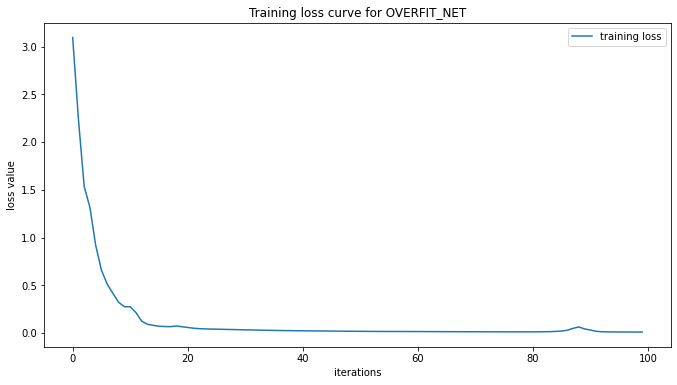

In [15]:
#%matplotlib inline
loss_graph = []
overfit_model = train_plot(EPOCH, basic_loader, overfit_model, optimizer, loss_graph)

## 6.3 Evaluate Overfitted Model's Performance

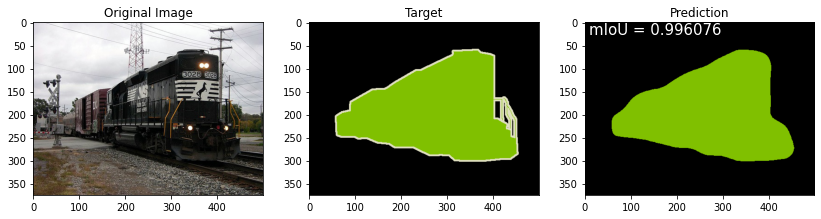

In [16]:
#%matplotlib notebook
plotPrediction(overfit_model, valTransform, img1, target1)

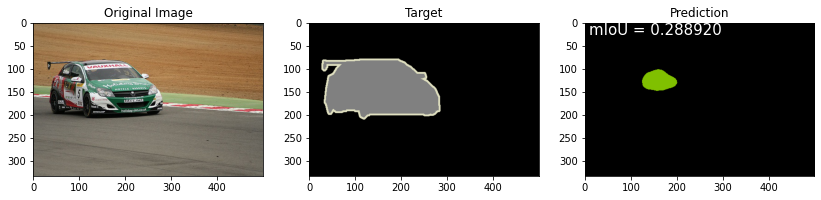

In [17]:
plotPrediction(overfit_model, valTransform, img2, target2)

In [23]:
torch.save(overfit_model.state_dict(), "drive/MyDrive/SemanticSegmentation/models/resnet18Overfit.pkl")
# device = torch.device("cuda")
# overfit_model = ResNet18(21)
# overfit_model.load_state_dict(torch.load("drive/MyDrive/SemanticSegmentation/models/resnet18.pkl", map_location="cuda:0"))  # Choose whatever GPU device number you want
# overfit_model.to(device)

# 7. Model Fitting

## 7.1 Configure Model

In [19]:
EPOCH = 4
criterion = nn.CrossEntropyLoss(ignore_index=255)

model = copy.deepcopy(untrained_model)
model.criterion = criterion
optimizer = torch.optim.SGD(model.parameters(),
                                lr=0.05,
                                weight_decay=1e-5,
                                momentum=0.2,
                                nesterov=False)

## 7.2 Model Training

Starting Training...
Epoch: 0 Loss: 0.8116371631622314
Epoch: 1 Loss: 0.7341380715370178
Epoch: 2 Loss: 0.4405326247215271
Epoch: 3 Loss: 1.46464204788208


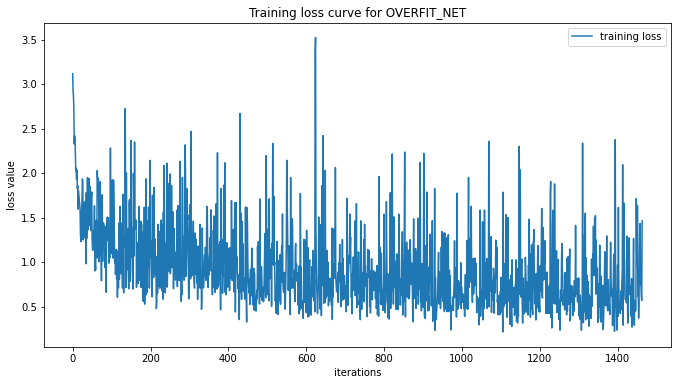

In [20]:
#%matplotlib notebook
loss_graph = []
model = train_plot(EPOCH, train_loader, model, optimizer, loss_graph, detail = True)
#%matplotlib inline

## 7.3 Evaluate Model's Performance

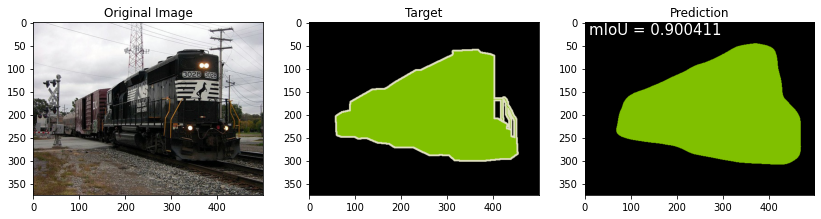

In [21]:
plotPrediction(model, valTransform, img1, target1)

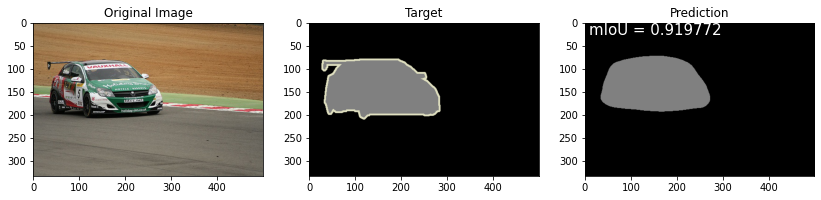

In [22]:
plotPrediction(model, valTransform, img2, target2)

In [25]:
torch.save(model.state_dict(), "drive/MyDrive/SemanticSegmentation/models/resnet18Fit.pkl")
# device = torch.device("cuda")
# model = ResNet18(21)
# model.load_state_dict(torch.load("drive/MyDrive/SemanticSegmentation/models/resnet18Fit.pkl", map_location="cuda:0"))  # Choose whatever GPU device number you want
# model.to(device)